In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import numpy as np
import math
import os
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

C:\Users\drodel\AppData\Local\Temp\ipykernel_15340\1689093467.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def load_dataset(data_path):
    source_columns = ["gx(rad/s)", "gy(rad/s)", "gz(rad/s)", "ax(m/s^2)", "ay(m/s^2)", "az(m/s^2)"]
    target_columns = ["px", "py", "pz"]
    
    source_sequences = []
    target_sequences = []
    
    for filename in os.listdir(data_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(data_path, filename)
        
            # Read the file using pandas
            df = pd.read_csv(file_path, sep=" ")
            
            # Extract required columns
            source_data = df[source_columns]
            target_data = df[target_columns]
        
            # Create source sequences of size (100, 6)
            for i in range(0, len(source_data) - 50, 50):
                source_seq = source_data.iloc[i:i+100, :].values
                source_sequences.append(source_seq)
        
            # Create target sequences of size (100, 3)
            for i in range(0, len(target_data) - 50, 50):
                target_seq = target_data.iloc[i:i+100, :].values
                target_sequences.append(target_seq)
        
            # Replace the last source sequence with the last 100 entries of the file
            last_source_seq = source_data.iloc[-100:, :].values
            source_sequences[-1] = last_source_seq
    
            # Replace the last target sequence with the last 100 entries of the file
            last_target_seq = target_data.iloc[-100:, :].values
            target_sequences[-1] = last_target_seq
    
    # Subtract the first row from all rows in each target sequence
    target_sequences = [seq - seq[0] for seq in target_sequences]
    
    # Convert source sequences to torch tensor
    source_tensors = torch.stack([torch.from_numpy(seq) for seq in source_sequences]).to(torch.float32)
    
    # Convert target sequences to torch tensor
    target_tensors = torch.stack([torch.from_numpy(seq) for seq in target_sequences]).to(torch.float32)
    
    # Create TensorDatasets
    dataset = TensorDataset(source_tensors, target_tensors)
    # target_dataset = TensorDataset(target_tensors)

    return dataset

In [3]:
train_data_path = './../dat/merged/train'
train_dataset = load_dataset(train_data_path)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_data_path = './../dat/merged/val'
val_dataset = load_dataset(val_data_path)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

test_data_path = './../dat/merged/test'
test_dataset = load_dataset(test_data_path)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [12]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        input_dim,
        output_dim,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.embedding_replacement_input = nn.Linear(input_dim, dim_model)
        self.embedding_replacement_output = nn.Linear(output_dim, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, output_dim)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length, input_dim)
        # Tgt size must be (batch_size, tgt sequence length, output_dim)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        # print(src.shape, tgt.shape)
        src = self.embedding_replacement_input(src) * math.sqrt(self.dim_model)
        tgt = self.embedding_replacement_output(tgt) * math.sqrt(self.dim_model)
        # print(src.shape, tgt.shape)
        src = self.positional_encoder(src)
        # tgt = self.positional_encoder(tgt)
        # print(src.shape, tgt.shape)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask

In [6]:
# example_data_batch = torch.ones((16,10,6))
# example_target_batch = 0.5*torch.ones((16,9,3))
# example_target_batch = torch.cat([torch.zeros((16,1,3)), example_target_batch], dim=1)

In [7]:
# data_loader = []
# for j in range(10):
#     example_data_batch = torch.cat([torch.arange(6).unsqueeze(0)+i for i in range(10)]).unsqueeze(0)
#     example_target_batch = torch.cat([torch.arange(3)])
# example_data_batch.shape

In [15]:
device = torch.device('cpu')
model = Transformer(
    input_dim=6, output_dim=3, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

c:\Users\drodel\Documents\Studium\Tuebingen\Semester_1__WS_2023\Virtual Humans\Exercises\Project_VH\IMU-Based-Tracking-of-Objects\venv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """

    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[0], batch[1]
        # X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        # y_input = y # torch.zeros(y.shape)
        # y_expected = y
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input, tgt_mask)
        # print(pred)

        # Permute pred to have batch size first again
        pred = pred.permute(1,0,2)     
        loss = loss_fn(pred, y_expected)
        # print(loss)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [17]:
def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[0], batch[1]
            # X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            # y_input = torch.zeros(y.shape)
            # y_expected = y
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            pred = pred.permute(1,0,2)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [18]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_loader, val_loader, 10)


Training and validating model
------------------------- Epoch 1 -------------------------


Training loss: 0.1629
Validation loss: 0.1182

------------------------- Epoch 2 -------------------------
Training loss: 0.1269
Validation loss: 0.0928

------------------------- Epoch 3 -------------------------
Training loss: 0.1064
Validation loss: 0.0771

------------------------- Epoch 4 -------------------------
Training loss: 0.0941
Validation loss: 0.0689

------------------------- Epoch 5 -------------------------
Training loss: 0.0862
Validation loss: 0.0618

------------------------- Epoch 6 -------------------------
Training loss: 0.0806
Validation loss: 0.0572

------------------------- Epoch 7 -------------------------
Training loss: 0.0778
Validation loss: 0.0540

------------------------- Epoch 8 -------------------------
Training loss: 0.0742
Validation loss: 0.0516

------------------------- Epoch 9 -------------------------
Training loss: 0.0724
Validation loss: 0.0502

------------------------- Epoch 10 -------------------------
Training loss: 0.0709
Validation los

In [45]:
def predict(model, input_sequence, max_length=10, SOS_token=2, EOS_token=3):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    # y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)
    y_input = torch.zeros((1,1,3))

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        # tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input)
        
        # next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        # next_item = torch.tensor([[next_item]], device=device)
        next_item = pred[0,:,:].unsqueeze(0)
        
        # print(y_input.shape, next_item.shape)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # # Stop if model predicts end of sentence
        # if next_item.view(-1).item() == EOS_token:
        #     break

    return y_input  # .view(-1).tolist()

In [44]:
model = torch.load(r"..\src\final_model.pt", map_location=torch.device('cpu'))

In [46]:
idx = 1
y_input = torch.zeros((1,1,3))
test_input = val_dataset[idx][0].unsqueeze(0)
test_output = val_dataset[idx][1].unsqueeze(0)

prediction = predict(model, test_input, max_length=10)

In [48]:
test_output.shape

torch.Size([1, 100, 3])

In [49]:
test_output[0][:10]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.8028e-03, -2.9057e-04, -1.4925e-04],
        [ 1.3587e-02, -5.8711e-04, -1.3494e-04],
        [ 2.0351e-02, -9.2334e-04,  6.8665e-05],
        [ 2.7099e-02, -1.2709e-03,  4.4799e-04],
        [ 3.3840e-02, -1.6357e-03,  1.0014e-03],
        [ 4.0590e-02, -2.0017e-03,  1.7178e-03],
        [ 4.7305e-02, -2.3494e-03,  2.6052e-03],
        [ 5.4007e-02, -2.7018e-03,  3.6330e-03],
        [ 6.0736e-02, -3.0637e-03,  4.7405e-03]])

In [50]:
prediction

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015],
         [ 0.0808, -0.0965,  0.0015]]], grad_fn=<CatBackward0>)

In [80]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)

c:\Users\drodel\Documents\Studium\Tuebingen\Semester_1__WS_2023\Virtual Humans\Exercises\Project_VH\IMU-Based-Tracking-of-Objects\venv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [42]:
import pickle
with open(r"..\src\val_loss_list.pkl", "rb") as f:
    val_loss_list = pickle.load(f)
with open(r"..\src\train_loss_list.pkl", "rb") as f:
    train_loss_list = pickle.load(f)

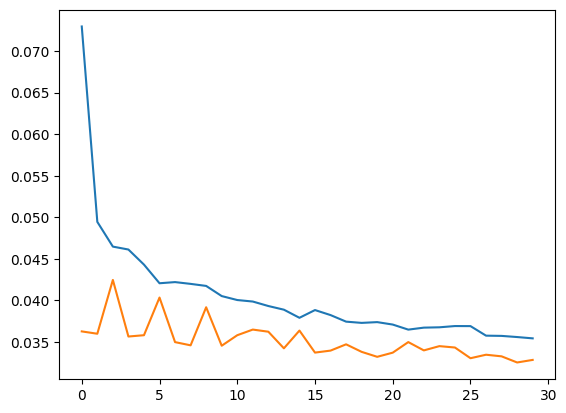

In [43]:
import matplotlib.pyplot as plt 
plt.plot(train_loss_list)
plt.plot(val_loss_list)